##### MNIST Image Recognition Based in Xgboost and Features extraction (main code)
####### by LIN Yingxin

#####  Copyright Notice

####### AUTHOR:

In [ ]:
#%     LIN Yingxin
#%     School of Finance, Central University of Finance and Economics(CUFE)

####### CONTACT:

In [ ]:
#%   Remaining errors are mine.
#%   For corrections about the code,
#%   please mail me at: lyxurthebest@163.com or lyxurthebest@outlook.com

####### ATTENTION:

In [1]:
#%   The copyright belongs to LIN Yingxin, 2021/08/11.
#%
#%   Enjoy! (...and extend/modify)

##### Introduction

- Different from the common practice of MNIST image recognition using CNN algorithm, I apply Numpy and OpenCV to extract relevant features from each MNIST figure, and then trains Xgboost recognition model. After gradually adjusting parameters, the accuracy of the optimal model on the test set can reach 88%.
- Because I've made extensive use of the broadcasting mechanism of NumPy instead of loops when coding, the code can run at an excellent speed.

##### 准备工作
###### 导入各种库

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
import pandas as pd
warnings.filterwarnings("ignore")
%matplotlib inline

###### 设置工作路径

In [2]:
cd C:\Users\Lenovo\1 MY_Code\My Data for 期末\MNIST\raw

C:\Users\Lenovo\1 MY_Code\My Data for 期末\MNIST\raw


###### 定义一个读入MNIST数据集的函数 load_mnist()

In [3]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

###### 读入Train_Set
####### X_train: 6000 * 784；其中，784 = 28 * 28
n：样例个数；p：每张图的像素点总数

In [4]:
file_path = "C:\\Users\\Lenovo\\1 MY_Code\\My Data for 期末\\MNIST\\raw"
X_train,y_train = load_mnist(file_path)
n, p = X_train.shape

###### 读入Test_Set

In [5]:
X_test, y_test = load_mnist(file_path, kind='t10k')

###### 展示原始图片

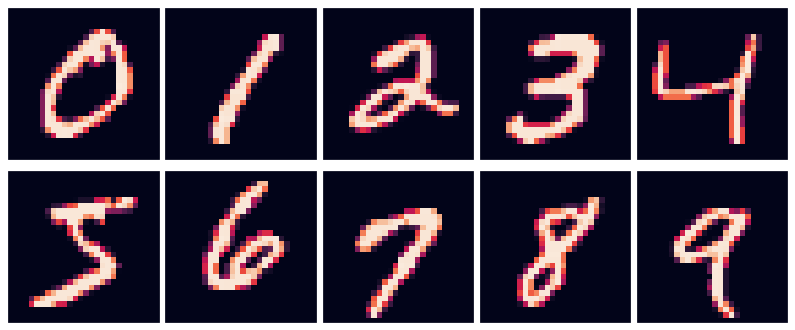

In [6]:
sns.set()
fig = plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.03, hspace=0.00001)
for i in range(10):
    plt.subplot(2,5,i+1)
    img = X_train[y_train == i][0].reshape(28, 28)
    plt.imshow(img , 
              #cmap='Greys',
              interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.show()

###### 以灰度图的形式展示

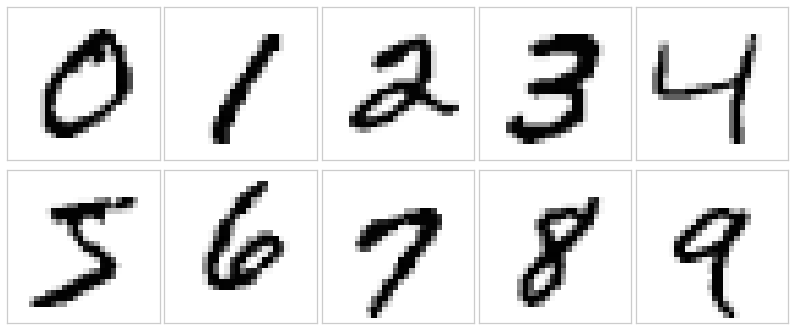

In [7]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.03, hspace=0.00001)
for i in range(10):
    plt.subplot(2,5,i+1)
    img = X_train[y_train == i][0].reshape(28, 28)
    plt.imshow(img , 
              cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.show()

##### 图片数据预处理与特征提取
###### 人眼看到的图片

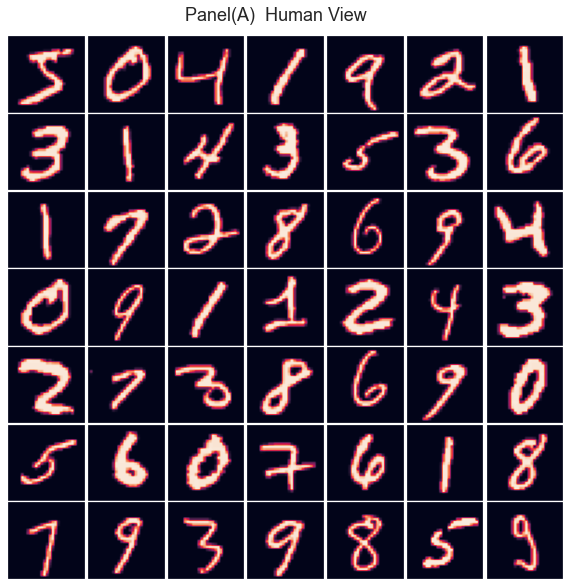

In [8]:
sns.set()
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    plt.subplot(7,7,i+1)
    img = X_train[i].reshape(28, 28)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Panel(A)  Human View",fontsize=18, y=0.92)
plt.show()

###### 实际上，计算机看到的图片

In [9]:
x_train = deepcopy(X_train)
x_train[x_train != 0] = 255

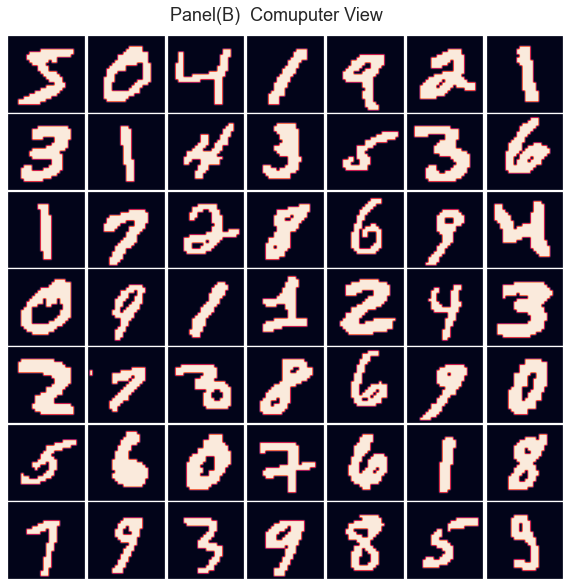

In [10]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    plt.subplot(7,7,i+1)
    img = x_train[i].reshape(28, 28)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Panel(B)  Comuputer View",fontsize=18, y=0.92)
plt.show()

###### 单样例均值变换——把 像素值>样例全部像素值均值的像素点 变为0；其他变为255
####### 考虑了每个人写字的轻重各不相同

In [6]:
xx_train = deepcopy(X_train)
threshold_mat = np.repeat(np.mean(xx_train, axis=1).reshape(n, 1)
                          , p, axis=1)
xx_train[xx_train <= threshold_mat] = 0
xx_train[xx_train != 0] = 255

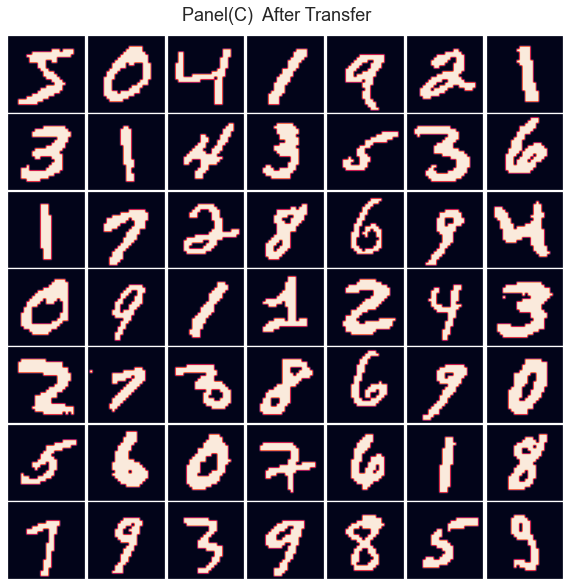

In [8]:
sns.set()
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    plt.subplot(7,7,i+1)
    img = xx_train[i].reshape(28, 28)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Panel(C)  After Transfer",fontsize=18, y=0.92)
plt.show()

###### 第1个特征——on像素的数量（num）
####### on_num()函数用于求该特征

In [237]:
def on_num(data):
    return np.count_nonzero(data, axis=1)
on_num(xx_train).shape

(60000,)

###### 获得所有on像素的 X坐标
####### 返回一个和 训练集 or 测试集等大小的矩阵，每一行的 每个、非0元素 对应 该位置的on像素 的X坐标

In [14]:
def xtick_on(data, m=28):
    
    '''data：训练集 or 测试集;
       n：样例数量；
       m：表示每张图片是 m * m 的矩阵。'''
    if np.ndim(data) == 1:
        n = 1
    n, _ = data.shape
    result = np.ravel(np.repeat(np.arange(1, m + 1).reshape(1, m),
                       repeats=m,
                       axis=0))  # axis=1时，有坑
    result = np.repeat(result.reshape(1, m * m),
                      repeats=n,
                      axis=0)
    result = (data != 0) * result
    return np.float64(result)  # 得转成float，否则下面的代码会报错：cannot convert float NaN to integer

######## 用热力图验证下有没有算错

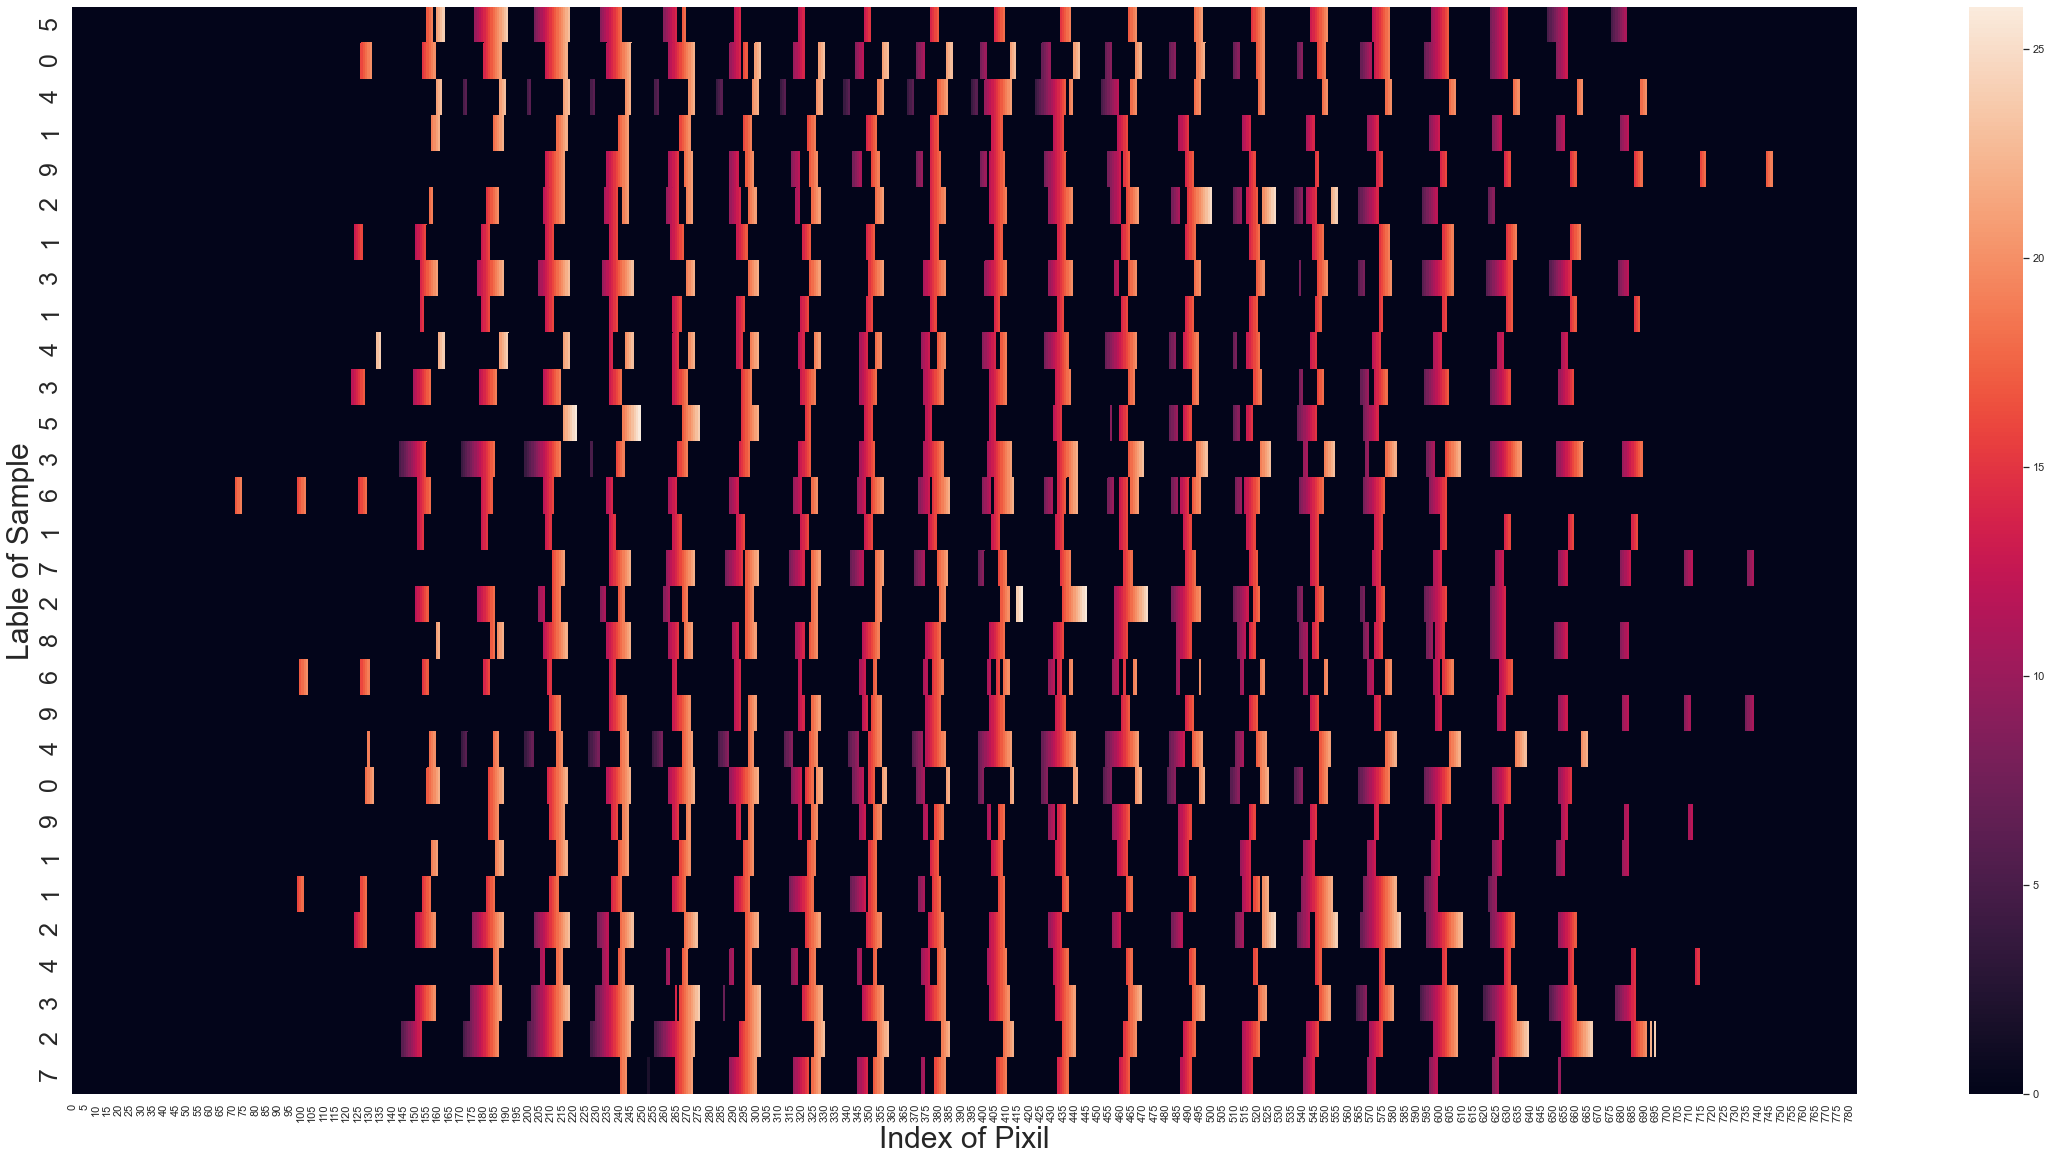

In [15]:
fig = plt.figure(figsize=(40,20))
sns.heatmap(xtick_on(xx_train[:30]), annot=False, yticklabels=y_train[:30])
plt.yticks(fontsize=25)
plt.ylabel("Lable of Sample", fontsize=30)
plt.xlabel("Index of Pixil", fontsize=30, y=0)
plt.show()

###### 获得on像素X坐标均值
####### 定义了一个x_mean_on()函数，该函数需调用前面的xtick_on()函数

In [16]:
def x_mean_on(data, m=28):
    
    result = xtick_on(data, m=m)
    result[result == 0] = np.nan  # 把0值全部转为NaN，这样就可以使用 np.nanmean() 啦
    return np.nanmean(result, axis=1)

(3, 60000)

In [ ]:
df_temp = pd.DataFrame(np.c_[x_mean_on(xx_train), x_std_on(xx_train), 
                                  np.int64(y_train)],
                       columns=['x_mean', 'x_std', 'Label'])

sns.set_style('whitegrid')
sns.pairplot(data=df_temp, hue='Label')
plt.show()

###### 获得on像素X坐标方差
####### 定义了一个x_std_on()函数，该函数需调用前面的xtick_on()函数

In [18]:
def x_std_on(data, m=28):
    
    result = xtick_on(data, m=m)
    result[result == 0] = np.nan  # 把0值全部转为NaN，这样就可以使用 np.nanmean() 啦
    return np.nanstd(result, axis=1)

In [19]:
x_std_on(xx_train).shape

(60000,)

###### 获得所有on像素的 Y坐标
####### 返回一个和 训练集 or 测试集等大小的矩阵，每一行的 每个、非0元素 对应 该位置的on像素 的Y坐标

In [20]:
def ytick_on(data, m=28):
    
    '''data：训练集 or 测试集;
       n：样例数量；
       m：表示每张图片是 m * m 的矩阵。'''
    if np.ndim(data) == 1:
        n = 1
    n, _ = data.shape
    result = np.repeat(np.arange(m, 0, -1).reshape(1, m),
                       repeats=m,
                       axis=1)  # If m=3，则当axis=1时，刚好是：[[1,1,1,2,2,2,3,3,3]]
    result = np.repeat(result.reshape(1, m * m),
                      repeats=n,
                      axis=0)
    result = (data != 0) * result
    return np.float64(result)  # 转成float

######## 用热力图验证下Y坐标有没有算错

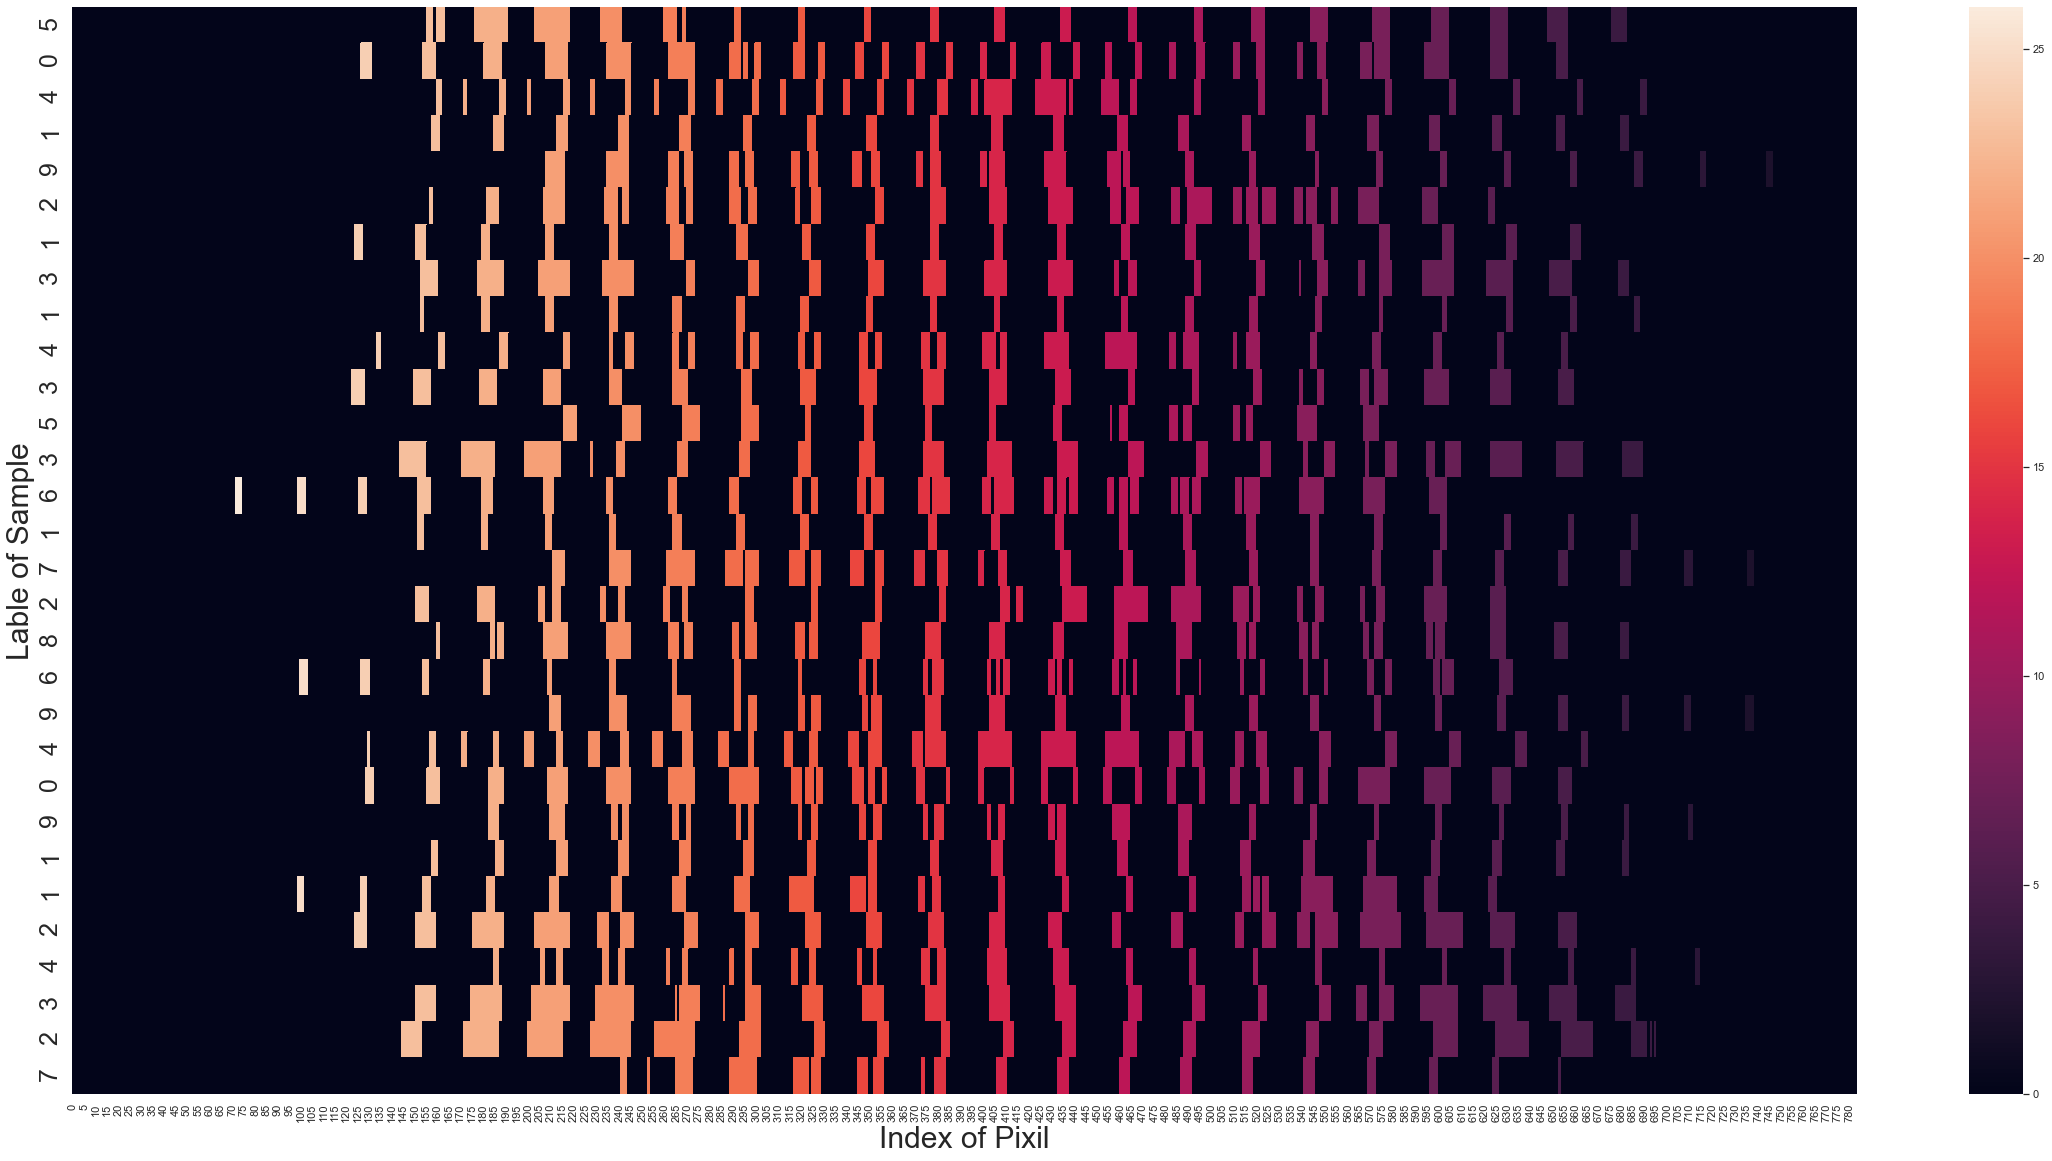

In [277]:
fig = plt.figure(figsize=(40,20))
sns.heatmap(ytick_on(xx_train[:30]), annot=False, yticklabels=y_train[:30])
plt.yticks(fontsize=25)
plt.ylabel("Lable of Sample", fontsize=30)
plt.xlabel("Index of Pixil", fontsize=30, y=0)
plt.show()

###### 获得on像素Y坐标均值
####### 定义了一个y_mean_on()函数，该函数需调用前面的ytick_on()函数

In [21]:
def y_mean_on(data, m=28):
    
    result = ytick_on(data, m=m)
    result[result == 0] = np.nan  # 把0值全部转为NaN，这样就可以使用 np.nanmean() 啦
    return np.nanmean(result, axis=1)

In [283]:
y_mean_on(xx_train).shape

(60000,)

###### 获得on像素Y坐标方差
####### 定义了一个y_std_on()函数，该函数需调用前面的ytick_on()函数

In [22]:
def y_std_on(data, m=28):
    
    result = ytick_on(data, m=m)
    result[result == 0] = np.nan  # 把0值全部转为NaN，这样就可以使用 np.nanmean() 啦
    return np.nanstd(result, axis=1)

In [285]:
y_std_on(xx_train).shape

(60000,)

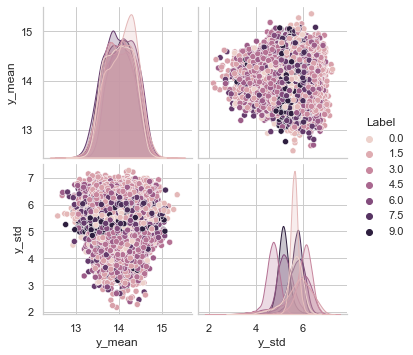

In [545]:
df_temp = pd.DataFrame(np.c_[y_mean_on(xx_train), y_std_on(xx_train), 
                                  np.int64(y_train)],
                       columns=['y_mean', 'y_std', 'Label'])

sns.set_style('whitegrid')
sns.pairplot(data=df_temp, hue='Label')
plt.show()

###### on像素X坐标与Y坐标相关系数
####### 定义了一个pearson()函数，该函数需调用前面的xtick_on() 和 ytick_on()函数

In [23]:
def pearson(data, m=28):
    
    n, _ = data.shape  # n：data内的样例个数
    
    x = xtick_on(data, m=m) # x：X坐标
    y = ytick_on(data, m=m) # y：Y坐标
    
    x[x == 0.0] = np.nan
    y[y == 0.0] = np.nan
    
    c_x = x - x_mean_on(data).reshape(n, 1)  # 中心化
    c_y = y - y_mean_on(data).reshape(n, 1)  # 这里NaN不会参与运算
    
    p1 = np.nansum(c_x * c_y, axis=1)  # p1: Pearson 的分子出来了; p1是一个1维数组
    p2 = (np.nansum(c_x ** 2, axis=1) * np.nansum(c_y ** 2, axis=1)) \
          ** 0.5  # p2：Pearson 的分母；p2亦是一个1维数组
    
    return p1 / p2

In [287]:
temp_df = pd.DataFrame(np.c_[pearson(xx_train), y_train], columns=['Pearson', 'Label'])
temp_df.Label = np.int0(temp_df.Label)
temp_df

,Pearson,Label
0,0.386401,5
1,0.399733,0
2,-0.114477,4
3,0.923105,1
4,0.002348,9
...,...,...
59995,0.573230,8
59996,0.547625,3
59997,0.389493,5
59998,0.378797,6


###### 画图验证下Pearson系数有没有算错

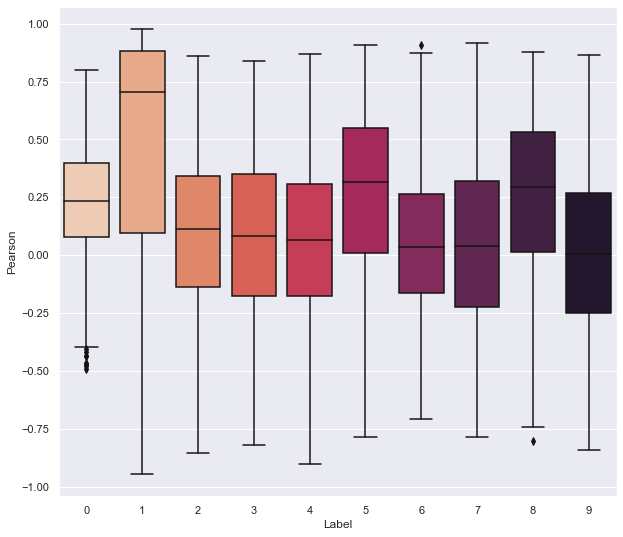

In [288]:
sns.set()
plt.figure(figsize=(10,9))
sns.boxplot(x="Label", y="Pearson", data=temp_df, palette="rocket_r")
plt.show()

###### on像素 X坐标的平方 * Y坐标 ，再求平均
####### 定义了一个x2_y()函数，该函数需调用前面的xtick_on() 和 ytick_on()函数

In [24]:
def x2_y(data, m=28):
    
    x = xtick_on(data, m=m)
    y = ytick_on(data, m=m)
    
    
    #temp = np.max(np.float16(((x==0) == (y==0))))
    
    x[x == 0.] = np.nan
    y[y == 0.] = np.nan
    
    x2 = x ** 2
    result = np.nanmean(x2 * y, axis=1)
    return result

In [293]:
x2_y(xx_train).shape

(60000,)

###### on像素 Y坐标的平方 * X坐标 ，再求平均
####### 定义了一个y2_x()函数，该函数需调用前面的xtick_on() 和 ytick_on()函数

In [25]:
def y2_x(data, m=28):
    
    x = xtick_on(data, m=m)
    y = ytick_on(data, m=m)
    
    x[x == 0.] = np.nan
    y[y == 0.] = np.nan
    
    y2 = y ** 2
    result = np.nanmean(y2 * x, axis=1)
    return result

###### 为求最小矩形框，导入 openCV 库

In [9]:
import cv2

###### 函数square_() 用于计算 数据集 的最大外接矩形 和 最小外接矩形的 一些特征

In [35]:
def square_(data, plot=False, m=28):
    
    if np.ndim(data) == 1:
        n = 1
    else:
        n, _ = data.shape
    
    result_1 = []
    result_2 = []
    result_3 = []
    box = None
    
    for i_ in range(n):

        thresh = xx_train[i_].reshape(m, m)
        
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            # 找到边界坐标
            x, y, w, h = cv2.boundingRect(c)  # 计算点集最外面的矩形边界

            # 找面积最小的矩形
            rect = cv2.minAreaRect(c)
            
            if plot == True:
                # 得到最小矩形的坐标
                box = cv2.boxPoints(rect)
                # 标准化坐标到整数
                box = np.int0(box)
                
        xy, hw, ratio = rect

        
        
        
        result_1.append((x, y, w, h))
        x, y = xy
        h, w = hw
        rect = [x, y, h, w, ratio]
        
        result_2.append(rect)
        result_3.append(box)
        
    return result_1, np.vstack(result_2), result_3

###### 绘图，观察最大外接矩形

In [31]:
_, temp, _ = square_(xx_train[:2], plot=True)
temp

array([[ 4.        ,  5.        , 20.        , 20.        , 10.61965466],
       [ 6.        ,  4.        , 20.        , 17.        , 45.        ]])

In [36]:
temp, _, _ = square_(xx_train[:50], plot=False)

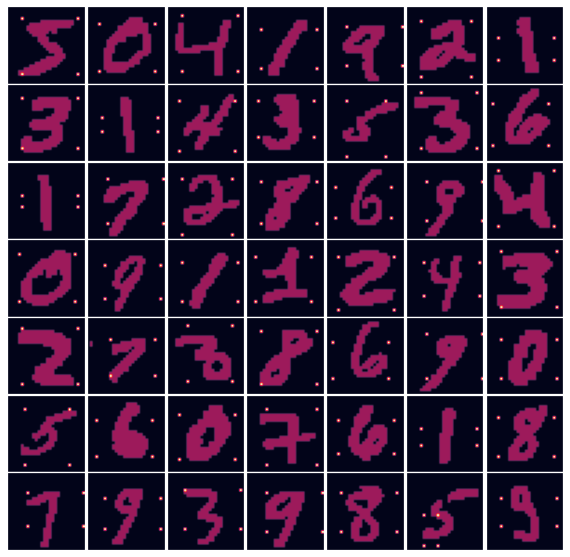

In [37]:
sns.set()
#sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    x, y, w, h = temp[i]
    img = (X_train[i].reshape(28, 28) != 0) * 100
    img[x, y] = 255
    img[x + w, y] = 255
    img[x, y + h] = 255
    img[x + w, y + h] = 255
    
    plt.subplot(7,7,i+1)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
#plt.suptitle("Panel(A)  Human View",fontsize=18, y=0.92)
plt.show()

###### 绘图，观察最小外接矩形

In [40]:
_, _, temp = square_(xx_train[:50], plot=True)
len(temp)

50

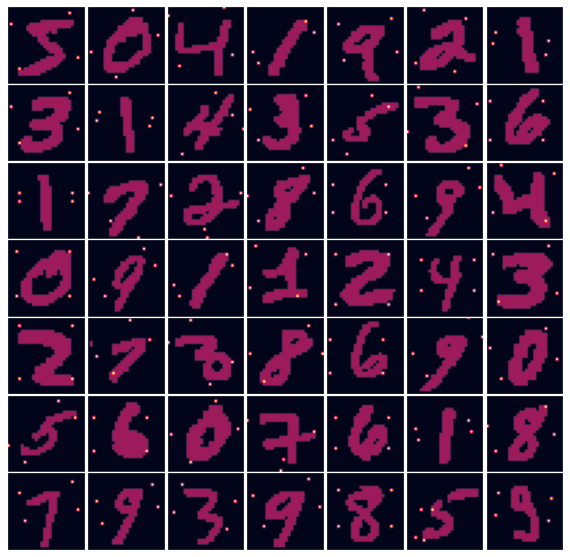

In [41]:
sns.set()
#sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    box = temp[i]
    img = (X_train[i].reshape(28, 28) != 0) * 100
    for j in range(4):
        x, y = tuple(box[j])
        img[x-1, y-1] = 255
    
    plt.subplot(7,7,i+1)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
#plt.suptitle("Panel(A)  Human View",fontsize=18, y=0.92)
plt.show()

###### 从右侧扫描的边缘数
####### 定义了一个right_scan()函数，接收的参数为图片矩阵

In [182]:
def right_scan(img):
    img = (img != 0)
    m, _ = img.shape
    #  图片矩阵整体右移，最右侧用0填充
    img_move_left = np.hstack([np.zeros((m, 1)), img[:, :-1]])
    ans_1 = ((img + img_move_left) == 1) * (img==0)
    #  图片矩阵整体上移，最下侧用0填充
    #img_move_up = np.vstack([img[1:, :] ,np.zeros((1, m))])
    #ans_2 = ((img + img_move_up) == 1)
    #  图片矩阵整体下移，最上侧用0填充
    #img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :] ])
    #ans_3 = ((img + img_move_down) == 1)
    ans = deepcopy(ans_1)
    #ans = (ans_1 + ans_2 + ans_3)
    num = np.sum(ans != 0)
    return num, ans

####### 画图检查效果-1

In [185]:
image = xx_train[1].reshape(28, 28)
num, flag = right_scan(image)
image[image != 0] = 150
image = image + (flag != 0) * 255

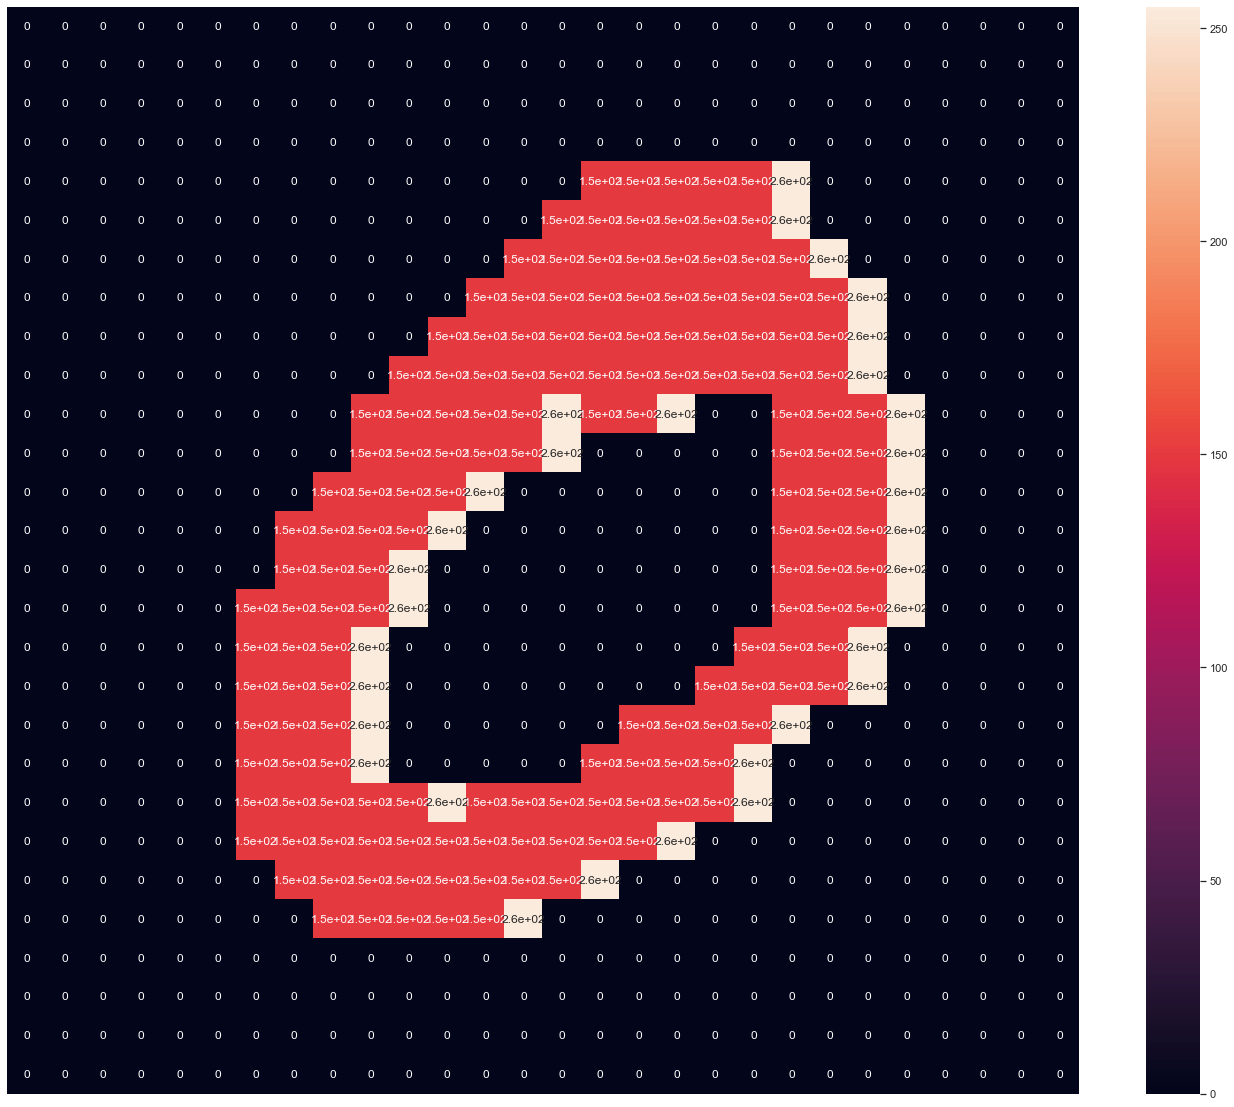

In [186]:
fig = plt.figure(figsize=(24,20))
sns.heatmap(image, annot=True)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

####### 画图检查效果-2

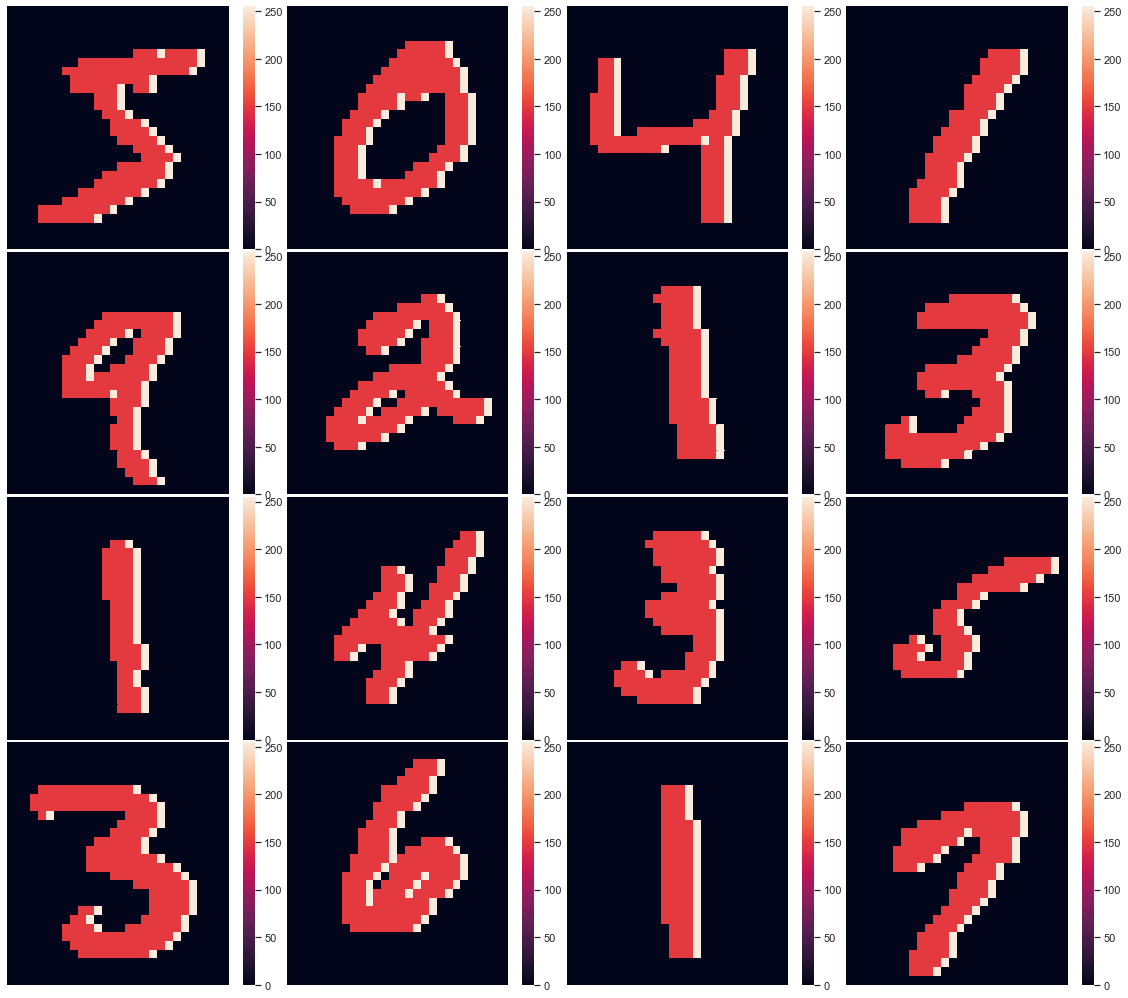

In [193]:
fig = plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(16):
    image = xx_train[i].reshape(28, 28)
    num, flag = right_scan(image)
    image[image != 0] = 150
    image = image + (flag != 0) * 255
    plt.subplot(4, 4, i + 1)
    sns.heatmap(image, annot=False)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.grid()
plt.show()

###### 从上方扫描的边缘数
####### 定义了一个up_scan()函数，接收的参数为图片矩阵

In [211]:
def up_scan(img):
    img = (img != 0)
    m, _ = img.shape
    #  图片矩阵整体右移，最右侧用0填充
    #img_move_left = np.hstack([np.zeros((m, 1)), img[:, :-1]])
    #ans_1 = ((img + img_move_left) == 1) * (img==0)
    #  图片矩阵整体上移，最下侧用0填充
    img_move_up = np.vstack([img[1:, :] ,np.zeros((1, m))])
    ans = ((img + img_move_up) == 1) * (img==0)
    #  图片矩阵整体下移，最上侧用0填充
    #img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :] ])
    #ans_3 = ((img + img_move_down) == 1)
    #ans = (ans_1 + ans_2 + ans_3)
    num = np.sum(ans != 0)
    return num, ans

####### 画图检查效果-1

In [212]:
image = xx_train[1].reshape(28, 28)
num, flag = up_scan(image)
image[image != 0] = 150
image = image + (flag != 0) * 255

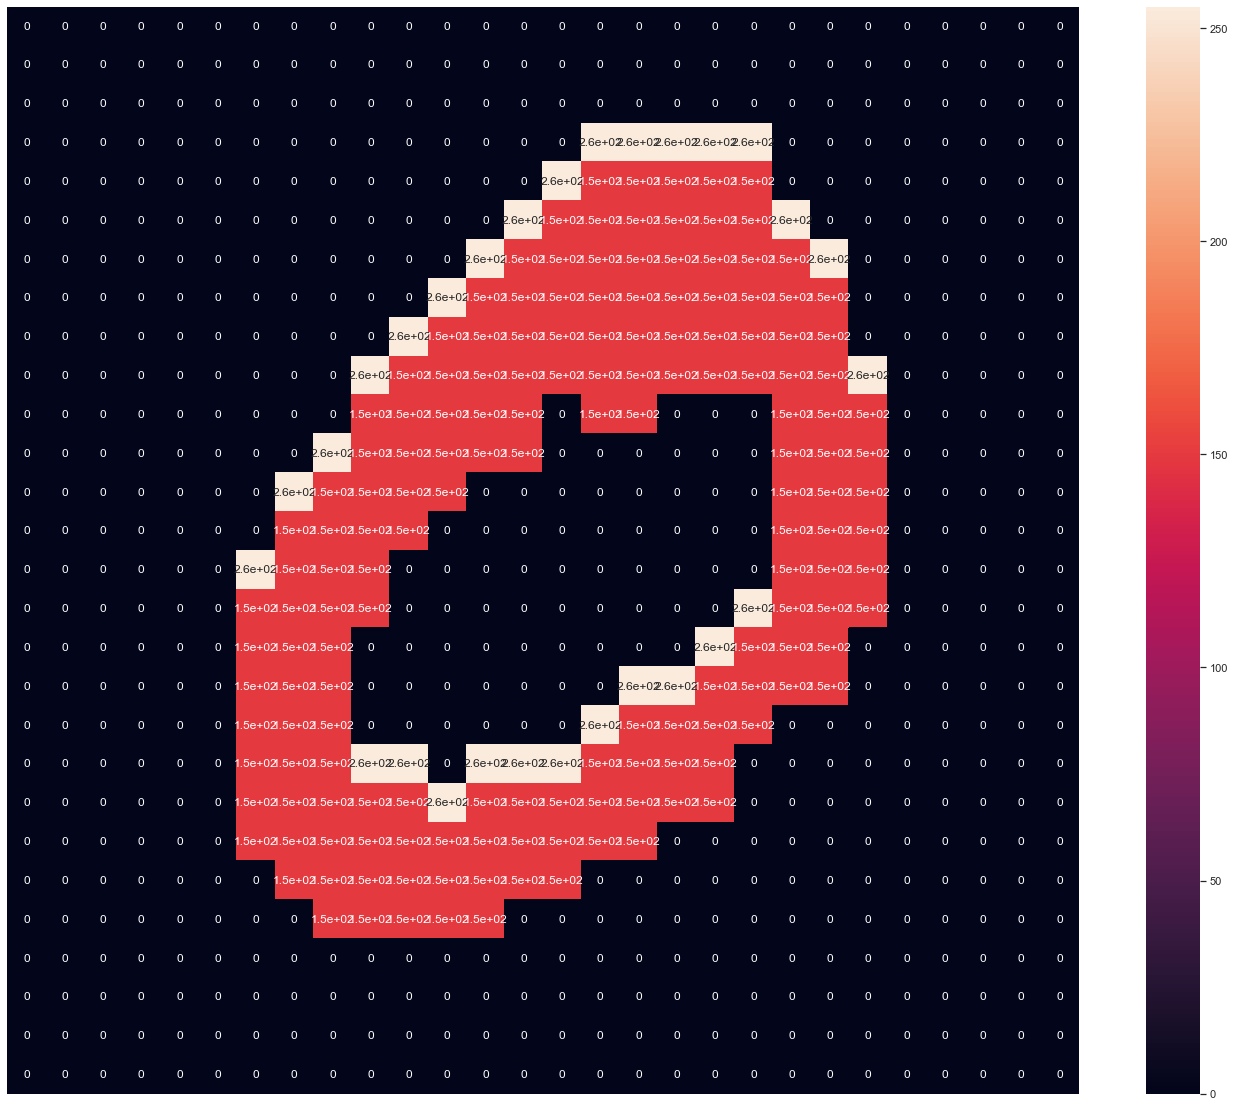

In [213]:
fig = plt.figure(figsize=(24,20))
sns.heatmap(image, annot=True)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

####### 画图检查效果-2

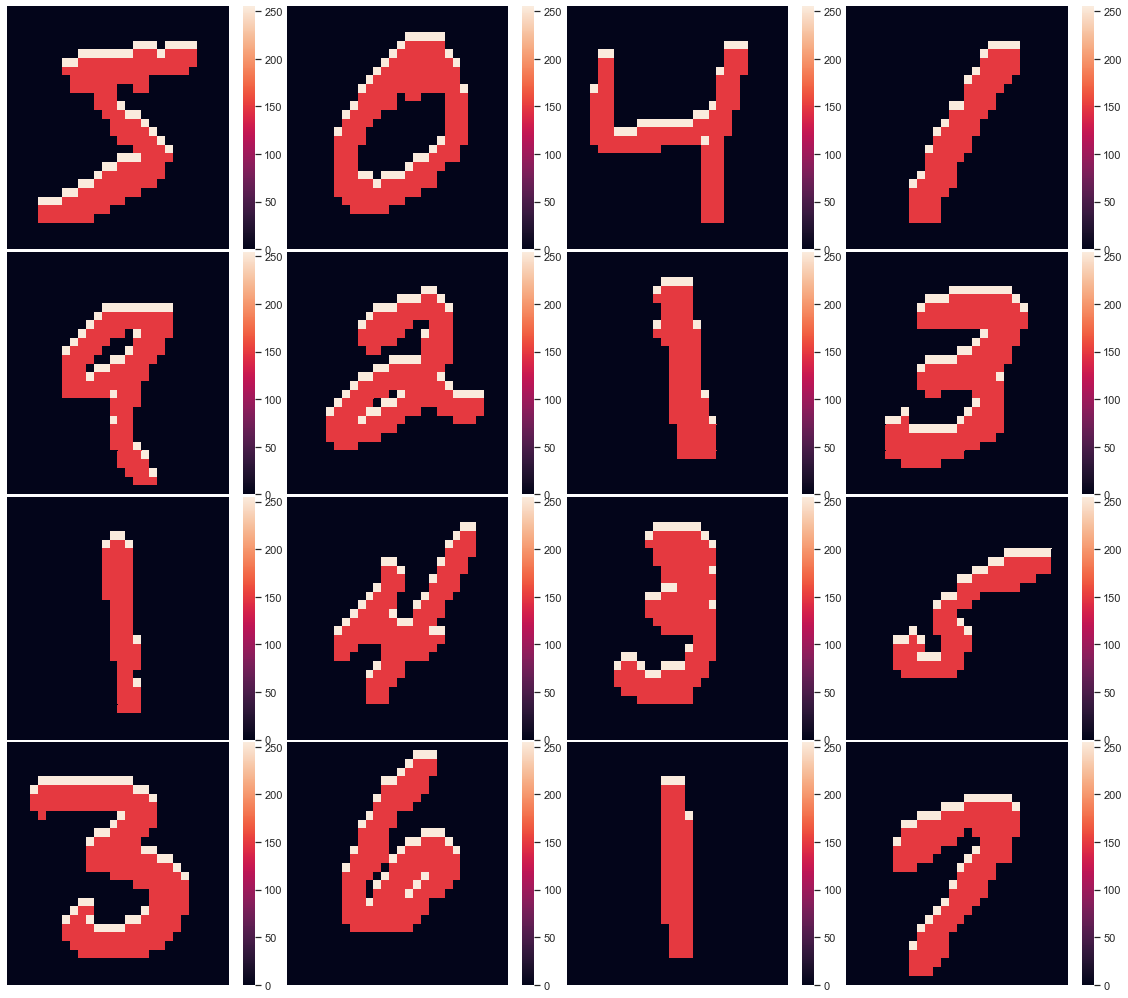

In [215]:
fig = plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(16):
    image = xx_train[i].reshape(28, 28)
    num, flag = up_scan(image)
    image[image != 0] = 150
    image = image + (flag != 0) * 255
    plt.subplot(4, 4, i + 1)
    sns.heatmap(image, annot=False)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.grid()
plt.show()

###### 从左方扫描的边缘数
####### 定义了一个left_scan()函数，接收的参数为图片矩阵

In [225]:
def left_scan(img):
    img = (img != 0)
    m, _ = img.shape
    #  图片矩阵整体右移，最右侧用0填充
    #img_move_left = np.hstack([np.zeros((m, 1)), img[:, :-1]])
    #ans_1 = ((img + img_move_left) == 1) * (img==0)
    #  图片矩阵整体上移，最下侧用0填充
    #img_move_up = np.vstack([img[1:, :] ,np.zeros((1, m))])
    #ans = ((img + img_move_up) == 1) * (img==0)
    #  图片矩阵整体下移，最上侧用0填充
    #img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :] ])
    #ans_3 = ((img + img_move_down) == 1)
    #ans = (ans_1 + ans_2 + ans_3)
    #  图片矩阵整体左移，最右侧用0填充
    img_move_left = np.hstack([img[:, 1:], np.zeros((m, 1))])
    ans = ((img + img_move_left) == 1) * (img==0)
    num = np.sum(ans != 0)
    return num, ans

####### 画图检查效果-1

In [226]:
image = xx_train[1].reshape(28, 28)
num, flag = left_scan(image)
image[image != 0] = 150
image = image + (flag != 0) * 255

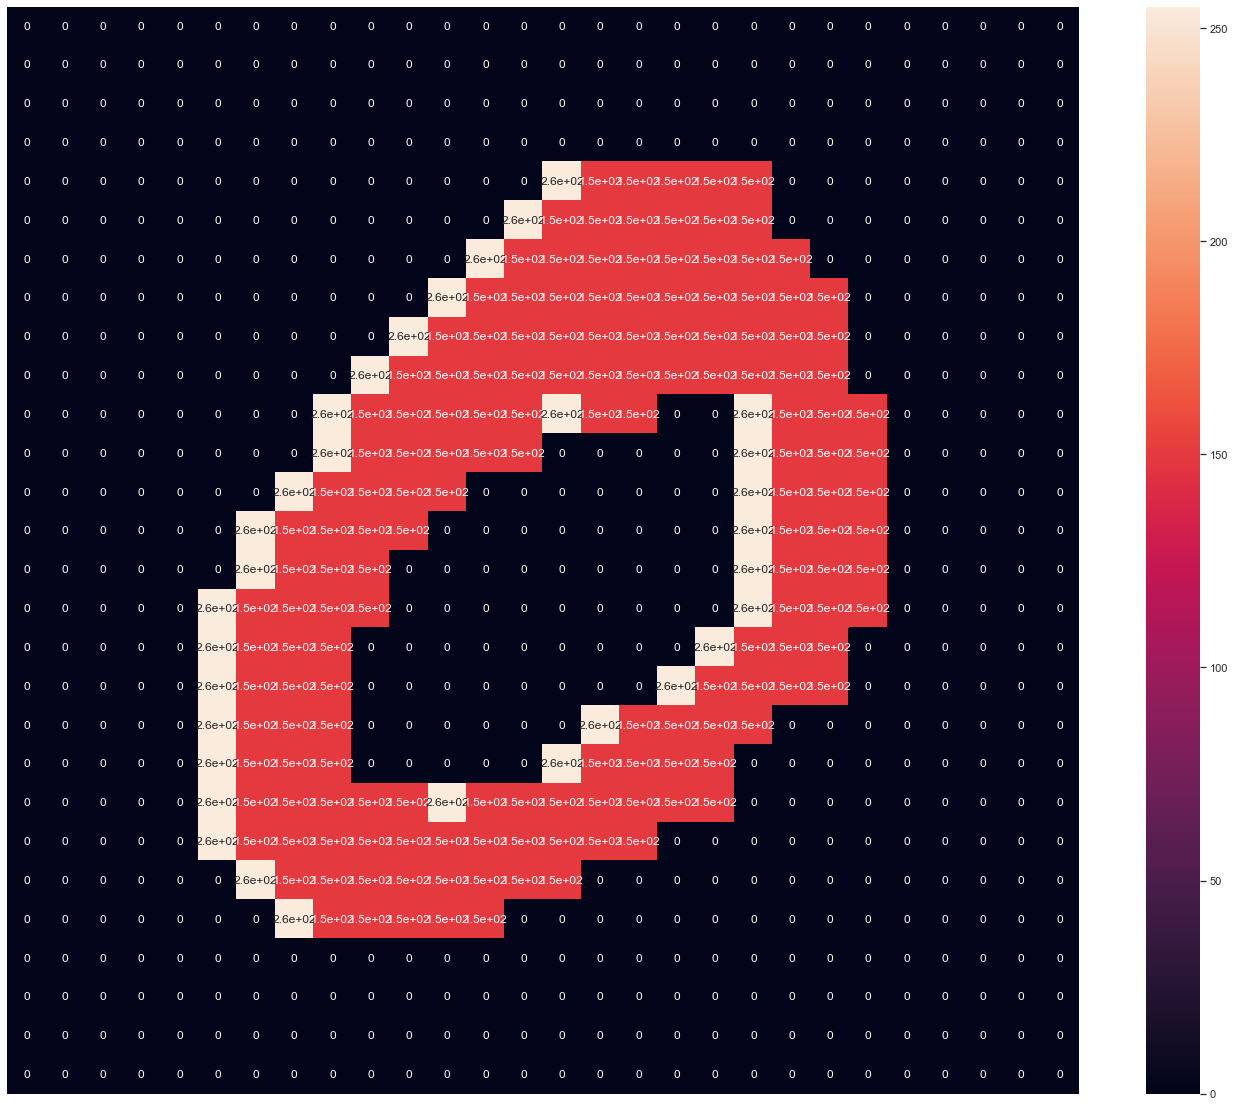

In [227]:
fig = plt.figure(figsize=(24,20))
sns.heatmap(image, annot=True)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

####### 画图检查效果-2

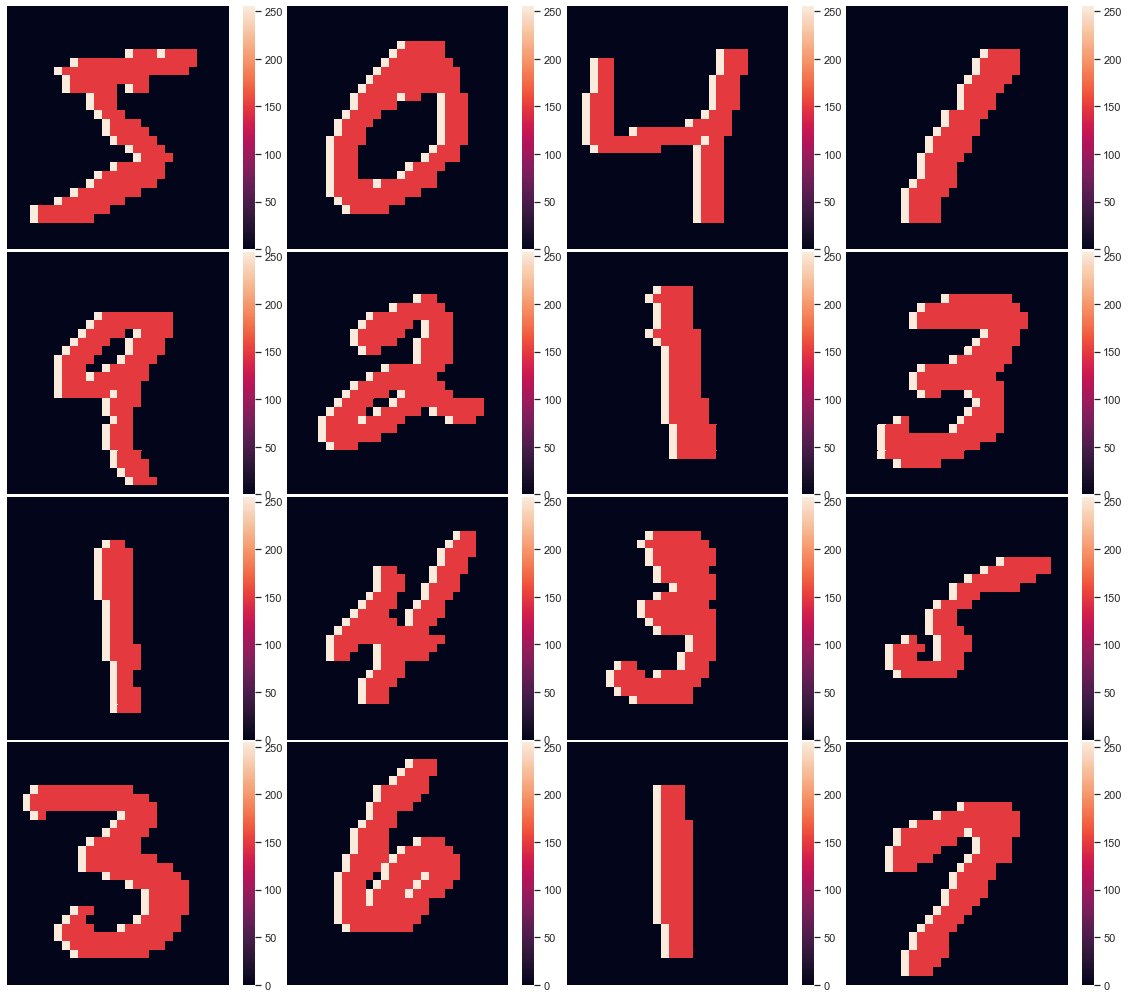

In [228]:
fig = plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(16):
    image = xx_train[i].reshape(28, 28)
    num, flag = left_scan(image)
    image[image != 0] = 150
    image = image + (flag != 0) * 255
    plt.subplot(4, 4, i + 1)
    sns.heatmap(image, annot=False)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.grid()
plt.show()

###### 从下方扫描的边缘数
####### 定义了一个down_scan()函数，接收的参数为图片矩阵

In [294]:
def down_scan(img):
    img = (img != 0)
    m, _ = img.shape
    #  图片矩阵整体右移，最右侧用0填充
    #img_move_left = np.hstack([np.zeros((m, 1)), img[:, :-1]])
    #ans_1 = ((img + img_move_left) == 1) * (img==0)
    #  图片矩阵整体上移，最下侧用0填充
    #img_move_up = np.vstack([img[1:, :] ,np.zeros((1, m))])
    #ans = ((img + img_move_up) == 1) * (img==0)
    #  图片矩阵整体下移，最上侧用0填充
    img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :]])
    ans = ((img + img_move_down) == 1) * (img == 0)
    num = np.sum(ans != 0)
    return num, ans

####### 画图检查效果-1

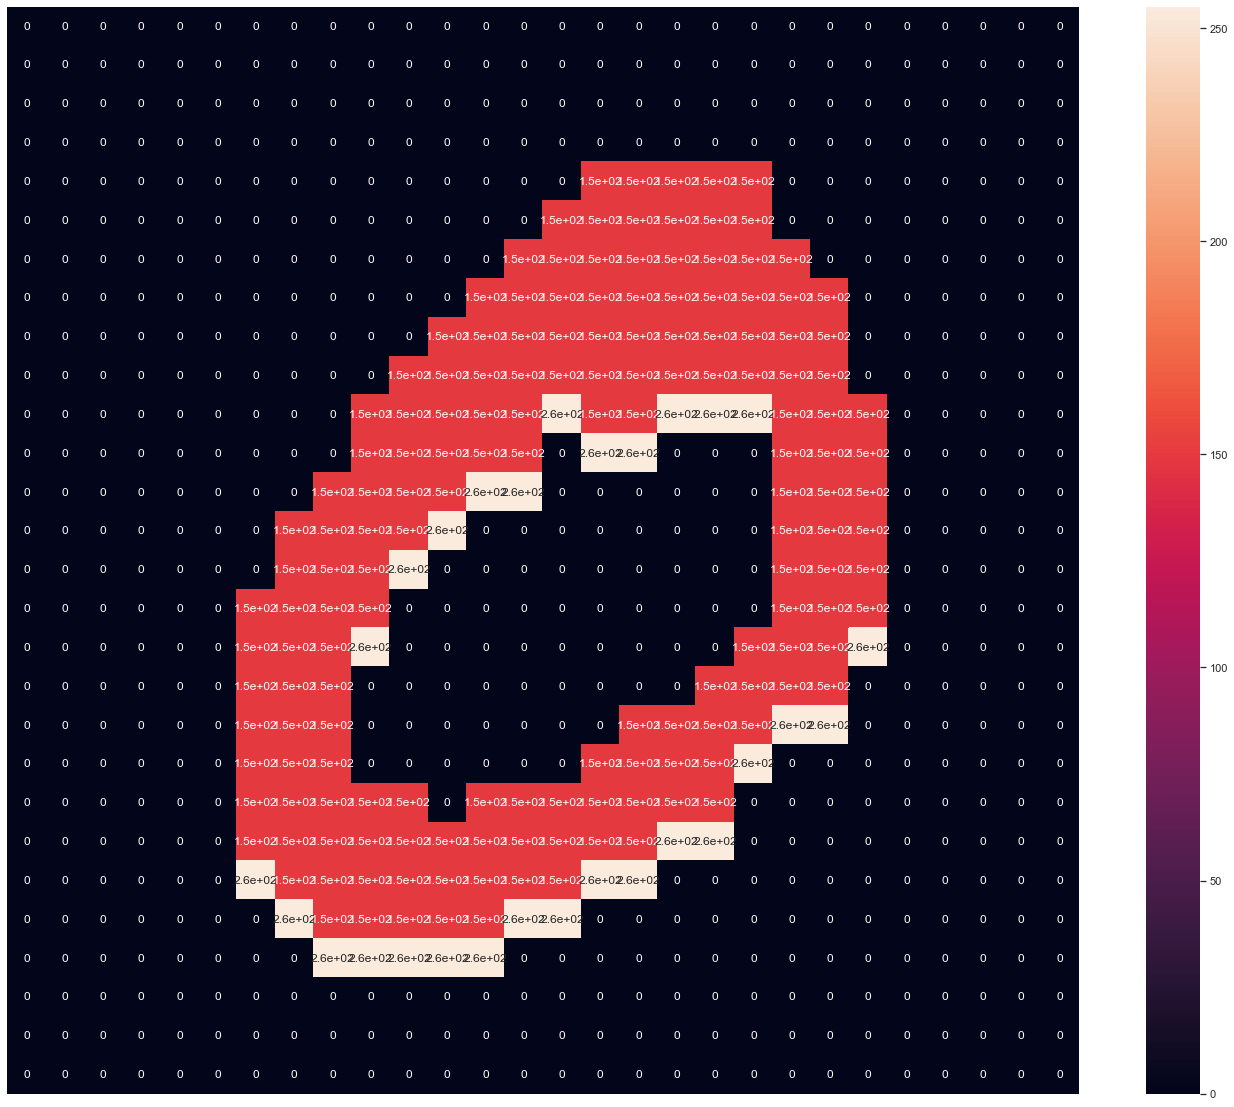

In [231]:
image = xx_train[1].reshape(28, 28)
num, flag = down_scan(image)
image[image != 0] = 150
image = image + (flag != 0) * 255
fig = plt.figure(figsize=(24,20))
sns.heatmap(image, annot=True)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

####### 画图检查效果-2

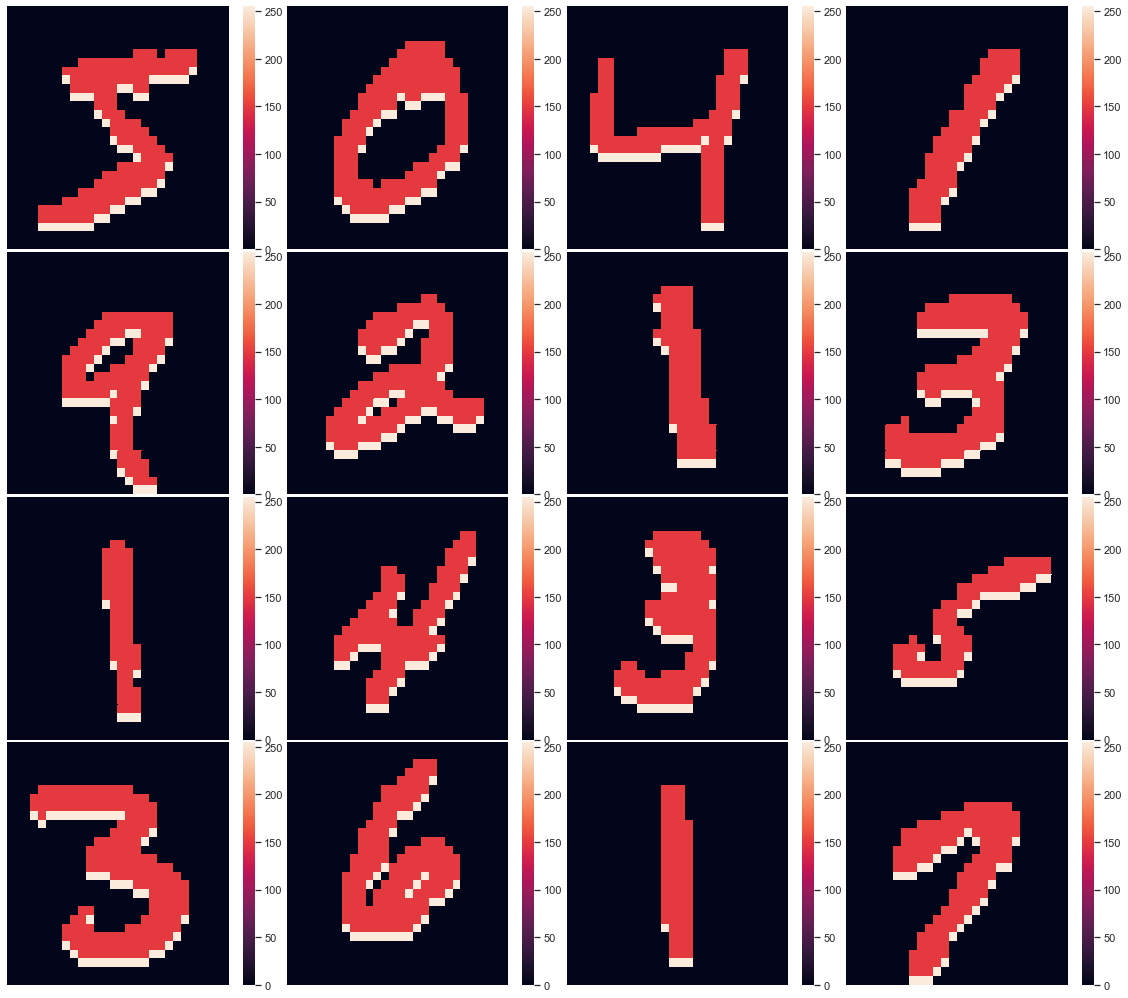

In [232]:
fig = plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(16):
    image = xx_train[i].reshape(28, 28)
    num, flag = down_scan(image)
    image[image != 0] = 150
    image = image + (flag != 0) * 255
    plt.subplot(4, 4, i + 1)
    sns.heatmap(image, annot=False)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.grid()
plt.show()

##### 对Train Set 和 Test Set做特征提取

###### 首先定义一个特征提取函数

In [295]:
def extract(data, m=28):
    
    n, _ = data.shape
    
    '''首先，是一些不用循环就能获得的特征的提取'''
    
    on_num_ = on_num(data)  # ON 像素的数量
    
    x_mean_on_ = x_mean_on(data)  # X 坐标均值
    
    x_std_on_ = x_std_on(data)  # X 坐标方差
    
    y_mean_on_ = y_mean_on(data)  # Y 坐标均值
    
    y_std_on_ = y_std_on(data)  # Y 坐标均值
    
    pearson_ = pearson(data)  # on像素X坐标与Y坐标相关系数
    
    x2_y_ = x2_y(data)  # on像素X坐标平方乘以Y坐标的平均
    
    y2_x_ = y2_x(data)  # on像素X坐标乘以Y坐标平方的平均
    
    featrue_class_1 = np.c_[on_num_, x_mean_on_, x_std_on_, y_mean_on_, y_std_on_,
                       pearson_, x2_y_, y2_x_]
    
    '''其次，是一些需要循环才能获得的特征的提取'''
    #  从左往右依次为：矩形框的 中心(x, y)、高、宽、倾斜角度，共计5个特征
    _, min_rectangle, _ = square_(data)  
    
    
    featrue_class_3 = [[ right_scan(data[i_].reshape(m, m))[0], 
                         left_scan(data[i_].reshape(m, m))[0], 
                         up_scan(data[i_].reshape(m, m))[0], 
                         down_scan(data[i_].reshape(m, m))[0] ] 
                         for i_ in range(n)]
    featrue_class_3 = np.vstack(featrue_class_3)

    return np.hstack([featrue_class_1, min_rectangle, featrue_class_3])

###### 从Train Set（已经过预处理）中提取特征

In [548]:
train = extract(xx_train)
train.shape

(60000, 17)

###### 对特征进行描述性统计

In [549]:
names = ['ON', 'X_mean', 'X_std', 'Y_mean', 'Y_std',
        'Pearson', 'x2_y', 'y2_x', 'x', 'y', 'H', 'W',
        'Theta', 'R', 'L', 'Up', 'Down', 'Label']
df = pd.DataFrame(data=np.hstack([train, y_train.reshape(len(y_train), 1)]), columns=names)
df.describe()

,ON,X_mean,X_std,Y_mean,Y_std,Pearson,x2_y,y2_x,x,y,H,W,Theta,R,L,Up,Down,Label
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,132.949150,15.008960,3.866059,14.019002,5.512494,0.159414,3487.115999,3503.163322,13.843586,13.980362,15.289626,16.978213,56.677430,25.688583,25.690300,25.560333,25.529300,4.453933
std,34.810672,0.317073,1.076686,0.333788,0.560549,0.372351,314.317728,290.543170,1.082033,1.326386,4.927215,4.933186,31.930691,4.588455,4.587153,8.807854,8.820378,2.889270
min,34.000000,13.771930,0.499836,12.576271,2.181039,-0.944964,2537.684211,2481.653846,1.000000,1.000000,0.000000,0.000000,-90.000000,10.000000,10.000000,2.000000,2.000000,0.000000
25%,109.000000,14.753521,3.221504,13.761905,5.156729,-0.114741,3258.432735,3299.922037,13.314640,13.426411,11.834764,13.000000,26.565050,22.000000,22.000000,20.000000,20.000000,2.000000
50%,132.000000,15.014286,3.934212,14.025316,5.589718,0.159816,3465.306565,3495.754698,13.902439,13.958739,17.919489,18.381739,61.699245,25.000000,25.000000,26.000000,26.000000,4.000000
75%,156.000000,15.263566,4.632101,14.277778,5.895031,0.432692,3695.731949,3700.731561,14.500000,14.553846,19.000000,20.571827,90.000000,29.000000,29.000000,32.000000,32.000000,7.000000
max,315.000000,16.307018,6.794792,15.357143,7.263519,0.975473,4961.107843,4652.170732,26.000000,18.500000,26.870058,26.870064,180.000000,48.000000,48.000000,62.000000,62.000000,9.000000


###### 查看特征间的相关性

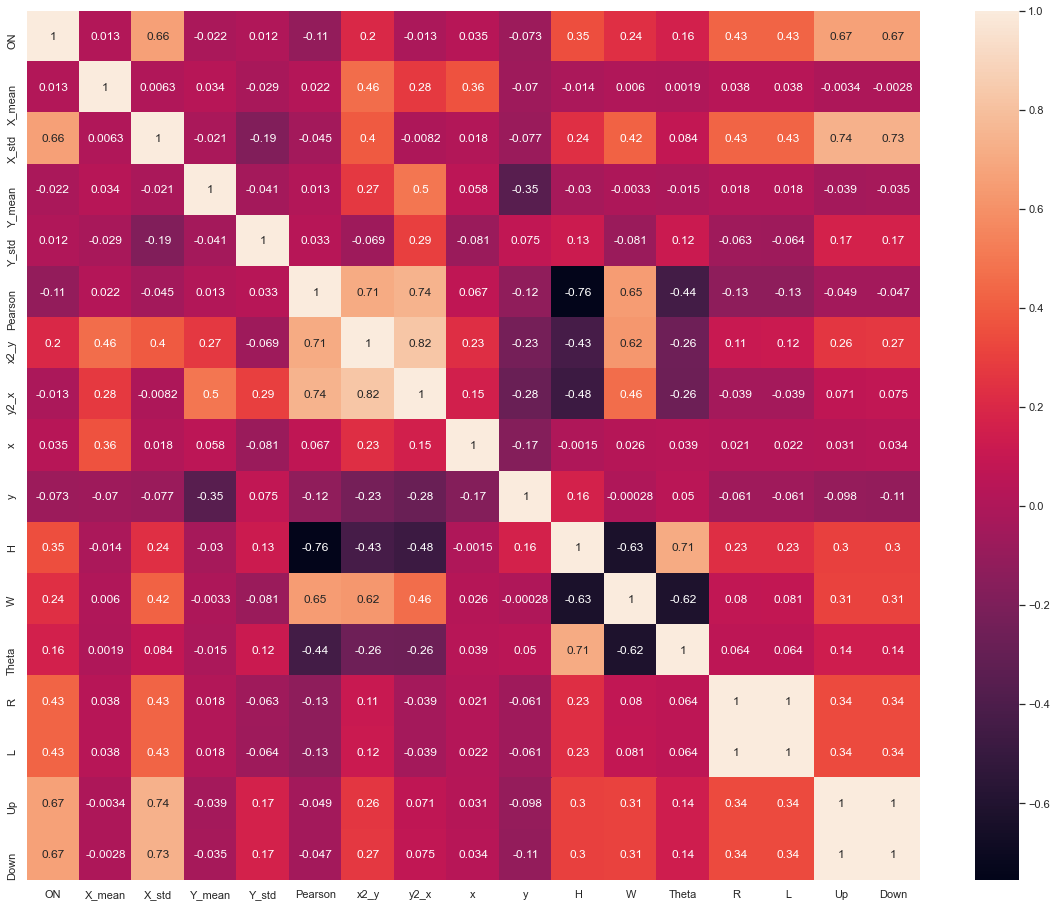

In [306]:
plt.figure(figsize=(20, 16))
sns.heatmap(data=df.corr(), annot=True)
plt.show()

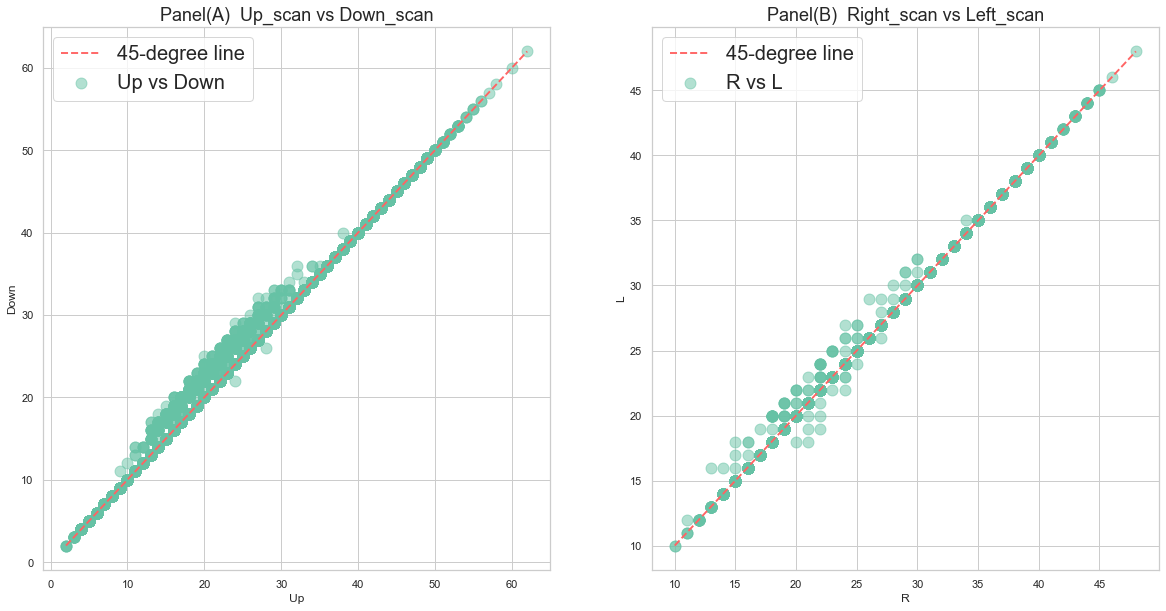

In [352]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Panel(A)  Up_scan vs Down_scan", fontsize=18)
plt.scatter(df.Down, df.Up, color='#66C2A5', alpha=0.5, s=120)
plt.plot([df.Down.min(), df.Up.max()], [df.Down.min(), df.Up.max()], 
         color="#FF6464",linestyle='--', lw=1.9)
plt.legend(["45-degree line", "Up vs Down"], fontsize=20)
plt.xlabel("Up")
plt.ylabel("Down")
plt.subplot(1, 2, 2)
plt.title("Panel(B)  Right_scan vs Left_scan", fontsize=18)
plt.scatter(df.R, df.L, color='#66C2A5', alpha=0.5, s=120)
plt.plot([df.R.min(), df.L.max()], [df.R.min(), df.L.max()], 
         color="#FF6464",linestyle='--', lw=1.9)
plt.legend(["45-degree line", "R vs L"], fontsize=20)
plt.xlabel("R")
plt.ylabel("L")
plt.show()

In [555]:
train = df.drop(columns=['Down', 'L'])[:12000]
train.shape

(12000, 16)

In [556]:
def split_train_test(data,test_ratio):
    #设置随机数种子，保证每次生成的结果都是一样的
    np.random.seed(42)
    #permutation随机生成0-len(data)随机序列
    shuffled_indices = np.random.permutation(len(data))
    #test_ratio为测试集所占的百分比
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    #iloc选择参数序列中所对应的行
    return data.iloc[train_indices],data.iloc[test_indices],train_indices,test_indices
 
#测试
train_set,test_set, id1, id2 = split_train_test(train,0.25)

In [553]:
train_set.to_excel("data.xlsx", index=None)

In [557]:
train = np.array(train_set)[:, 0:-1]
test = np.array(test_set)[:, 0:-1]
y_train = np.array(train_set)[:, -1]
y_test = np.array(test_set)[:, -1]

##### 训练 Xgboost

###### 导入 xgboost 包

In [331]:
import xgboost as xgb

###### 初始模型（未调参）

In [392]:
param_dist = {'objective': 'multi:softmax', 
              'n_estimators': 1000,
              
               'num_class': 10,  # 分成的类数
              'eta': 0.01,  # 学习率
              'alpha': 1,  # 惩罚项参数：γ
              'lambda': 0.001,  # 惩罚项参数：λ
              'use_label_encoder': False,
              #'metric': 'multiclass',
              'eval_metric': 'mlogloss'
              # 'metric': multiclass
              # 'subsample': 0.9
              }
# 建立一个初步的模型，看一下效果怎么样。
xgb_model = xgb.XGBClassifier(**param_dist)

In [393]:
xgb_model.fit(train, y_train)  # 拟合
xgb_result = xgb_model.predict(test, iteration_range = (0, 1000) )
np.mean(xgb_result == y_test)

0.8473333333333334

###### 调参1：惩罚系数

In [396]:
alphas = np.logspace(-8, 0, 50, base = 10)

In [408]:
y_train = np.int64(y_train)
y_test = np.int64(y_test)

In [409]:
dtrain = xgb.DMatrix(train, label=y_train)
dtest = xgb.DMatrix(test, label=y_test)

In [411]:
result_ls = []
for i in range(len(alphas)):

    param_dict = {'objective': 'multi:softmax', 
                  'num_class': 10,
                  'eta': 0.01, 
                  'alpha': alphas[i],
                  'lambda': 0.001,
                  'eval_metric': 'mlogloss'}
    xgb_cv = xgb.cv(param_dict, dtrain, 
                num_boost_round=1000, 
                nfold=5, stratified=True,
                early_stopping_rounds=10, metrics='merror')

    temp = np.array(xgb_cv)
    result_ls.append(temp[-1])
    param_dic
    print(">>>> 第{}个参数测试完毕！".format(i + 1))

In [413]:
result1 = np.vstack(result_ls)
result1.shape

(50, 4)

In [454]:
error_mean = result1[:, 0]
error_std = result1[:, 1]
CV_std = result1[:,3]
CV_mean = result1[:, 2]

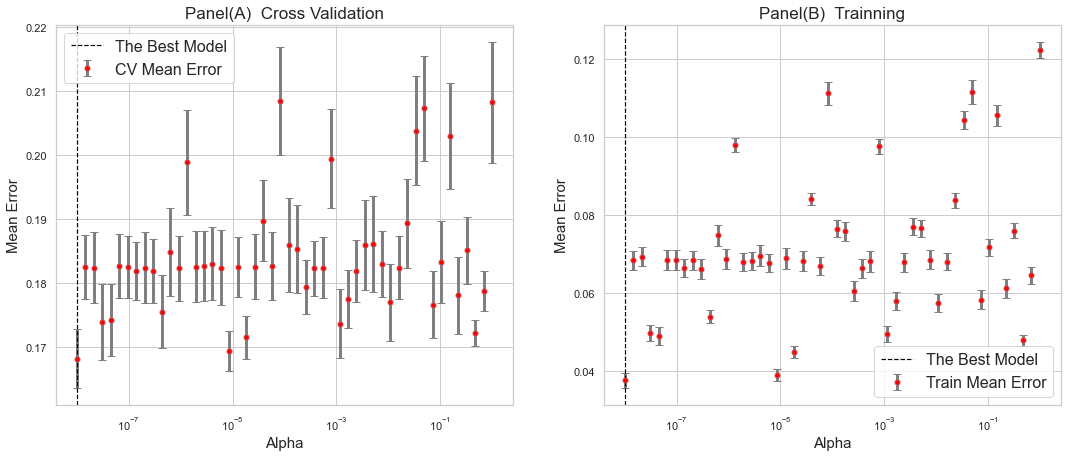

In [455]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.errorbar(alphas, CV_mean    #x, y数据，一一对应
             , yerr=CV_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )                      #误差棒边界线厚度

plt.semilogx()
plt.axvline(alphas[np.argmin(CV_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','CV Mean Error'], fontsize=16)
plt.xlabel('Alpha', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(A)  Cross Validation", fontsize = 17)
plt.subplot(1, 2, 2)
plt.errorbar(alphas, error_mean    #x, y数据，一一对应
             , yerr=error_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )
plt.semilogx()
plt.axvline(alphas[np.argmin(CV_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','Train Mean Error'], fontsize=16)
plt.xlabel('Alpha', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(B)  Trainning", fontsize = 17)
plt.show()

###### 保存下调整惩罚率后的模型

In [445]:
best_alpha = alphas[0]
best_alpha

1e-08

In [473]:
param_dict = {'objective': 'multi:softmax',
              'n_estimators': 1000,
              'num_class': 10,
              'eta': 0.01, 
              'alpha': best_alpha,
              'lambda': 0.001,
              'eval_metric': 'mlogloss'}

###### 计算调整Alpha后的准确率

In [558]:
xgb_model_1 = xgb.XGBClassifier(**param_dict)
xgb_model_1.fit(train, y_train)  # 拟合

xgb_result1 = xgb_model_1.predict(test, iteration_range = (0, 1000) )
np.mean(xgb_result1 == y_test)

0.8636666666666667

###### 调学习率

In [447]:
etas = np.logspace(-4, 0, 30, base = 10)

In [449]:
result_ls = []
for i in range(len(etas)):

    param_dict = {'objective': 'multi:softmax', 
                  'num_class': 10,
                  'eta': etas[i], 
                  'alpha': best_alpha,
                  'lambda': 0.001,
                  'eval_metric': 'mlogloss'}
    xgb_cv = xgb.cv(param_dict, dtrain, 
                num_boost_round=1000, 
                nfold=5, stratified=True,
                early_stopping_rounds=10, metrics='merror')

    temp = np.array(xgb_cv)
    result_ls.append(temp[-1])
    print(">>>> 第{}个参数 eta={} 测试完毕！".format(i + 1, etas[i]))

>>>> 第1个参数 eta=0.0001 测试完毕！
>>>> 第2个参数 eta=0.00013738237958832623 测试完毕！
>>>> 第3个参数 eta=0.00018873918221350977 测试完毕！
>>>> 第4个参数 eta=0.0002592943797404667 测试完毕！
>>>> 第5个参数 eta=0.0003562247890262444 测试完毕！
>>>> 第6个参数 eta=0.0004893900918477494 测试完毕！
>>>> 第7个参数 eta=0.0006723357536499335 测试完毕！
>>>> 第8个参数 eta=0.0009236708571873865 测试完毕！
>>>> 第9个参数 eta=0.0012689610031679222 测试完毕！
>>>> 第10个参数 eta=0.0017433288221999873 测试完毕！
>>>> 第11个参数 eta=0.002395026619987486 测试完毕！
>>>> 第12个参数 eta=0.0032903445623126675 测试完毕！
>>>> 第13个参数 eta=0.004520353656360241 测试完毕！
>>>> 第14个参数 eta=0.006210169418915616 测试完毕！
>>>> 第15个参数 eta=0.008531678524172805 测试完毕！
>>>> 第16个参数 eta=0.011721022975334805 测试完毕！
>>>> 第17个参数 eta=0.01610262027560939 测试完毕！
>>>> 第18个参数 eta=0.02212216291070448 测试完毕！
>>>> 第19个参数 eta=0.03039195382313198 测试完毕！
>>>> 第20个参数 eta=0.041753189365604 测试完毕！
>>>> 第21个参数 eta=0.05736152510448681 测试完毕！
>>>> 第22个参数 eta=0.07880462815669913 测试完毕！
>>>> 第23个参数 eta=0.1082636733874054 测试完毕！
>>>> 第24个参数 eta=0.14873521072935

In [450]:
result2 = np.vstack(result_ls)
result2.shape

(30, 4)

In [484]:
error_mean = result2[:, 0]
error_std = result2[:, 1]
CV_std = result2[:,3]
CV_mean = result2[:, 2]

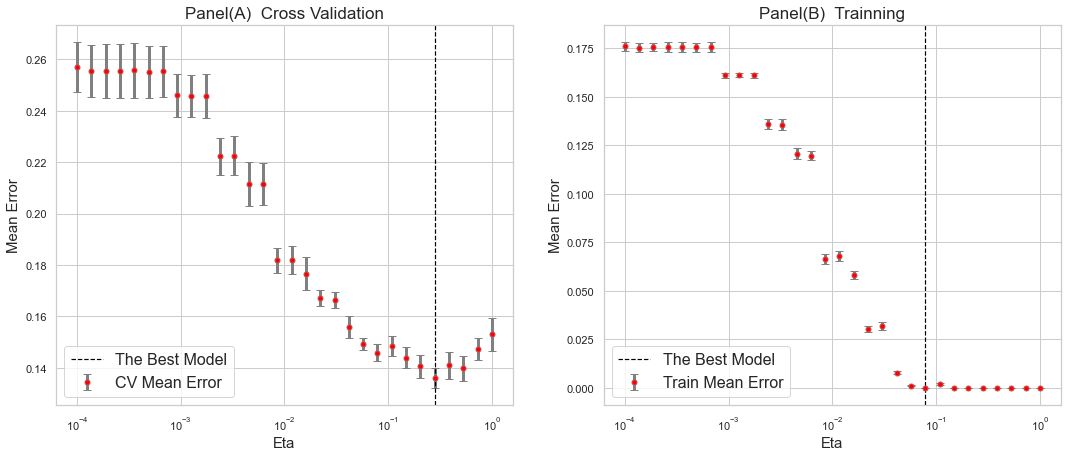

In [485]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.errorbar(etas, CV_mean    #x, y数据，一一对应
             , yerr=CV_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )                      #误差棒边界线厚度

plt.semilogx()
plt.axvline(etas[np.argmin(CV_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','CV Mean Error'], fontsize=16)
plt.xlabel('Eta', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(A)  Cross Validation", fontsize = 17)
plt.subplot(1, 2, 2)
plt.errorbar(etas, error_mean    #x, y数据，一一对应
             , yerr=error_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )
plt.semilogx()
plt.axvline(etas[np.argmin(error_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','Train Mean Error'], fontsize=16)
plt.xlabel('Eta', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(B)  Trainning", fontsize = 17)
plt.show()

###### 保存下最优的 Eta

In [459]:
best_eta = etas[np.argmin(CV_mean)]
best_eta

0.2807216203941176

In [470]:
param_dict = {'objective': 'multi:softmax',
              'n_estimators': 1000,
              'num_class': 10,
              'eta': best_eta, 
              'alpha': best_alpha,
              'lambda': 0.001,
              'eval_metric': 'mlogloss'}

In [ ]:
xgb_model_2 = xgb.XGBClassifier(**param_dict)
xgb_model_2.fit(train, y_train)  # 拟合

In [489]:
xgb_result2 = xgb_model_2.predict(test, iteration_range = (0, 1000) )
np.mean(xgb_result2 == y_test)

0.867

###### 调整 Lambda

In [478]:
lambdas = np.logspace(-5, 0, 0, base = 10)

In [479]:
result_ls = []
for i in range(len(lambdas)):

    param_dict = {'objective': 'multi:softmax', 
                  'num_class': 10,
                  'eta': best_eta, 
                  'alpha': best_alpha,
                  'lambda': lambdas[i],
                  'eval_metric': 'mlogloss'}
    xgb_cv = xgb.cv(param_dict, dtrain, 
                num_boost_round=1000, 
                nfold=5, stratified=True,
                early_stopping_rounds=10, metrics='merror')

    temp = np.array(xgb_cv)
    result_ls.append(temp[-1])
    print(">>>> 第{}个参数 lambda={} 测试完毕！".format(i + 1, lambdas[i]))

>>>> 第1个参数 lambda=1e-05 测试完毕！
>>>> 第2个参数 lambda=1.2648552168552958e-05 测试完毕！
>>>> 第3个参数 lambda=1.5998587196060572e-05 测试完毕！
>>>> 第4个参数 lambda=2.0235896477251556e-05 测试完毕！
>>>> 第5个参数 lambda=2.559547922699533e-05 测试完毕！
>>>> 第6个参数 lambda=3.237457542817647e-05 测试完毕！
>>>> 第7个参数 lambda=4.094915062380427e-05 测试完毕！
>>>> 第8个参数 lambda=5.1794746792312125e-05 测试完毕！
>>>> 第9个参数 lambda=6.55128556859551e-05 测试完毕！
>>>> 第10个参数 lambda=8.286427728546843e-05 测试完毕！
>>>> 第11个参数 lambda=0.00010481131341546853 测试完毕！
>>>> 第12个参数 lambda=0.00013257113655901095 测试完毕！
>>>> 第13个参数 lambda=0.00016768329368110083 测试完毕！
>>>> 第14个参数 lambda=0.00021209508879201905 测试完毕！
>>>> 第15个参数 lambda=0.0002682695795279727 测试完毕！
>>>> 第16个参数 lambda=0.000339322177189533 测试完毕！
>>>> 第17个参数 lambda=0.00042919342601287783 测试完毕！
>>>> 第18个参数 lambda=0.0005428675439323859 测试完毕！
>>>> 第19个参数 lambda=0.0006866488450042998 测试完毕！
>>>> 第20个参数 lambda=0.000868511373751353 测试完毕！
>>>> 第21个参数 lambda=0.0010985411419875584 测试完毕！
>>>> 第22个参数 lambda=0.00138949549

In [480]:
result3 = np.vstack(result_ls)
result3.shape

(50, 4)

In [481]:
error_mean = result3[:, 0]
error_std = result3[:, 1]
CV_std = result3[:,3]
CV_mean = result3[:, 2]

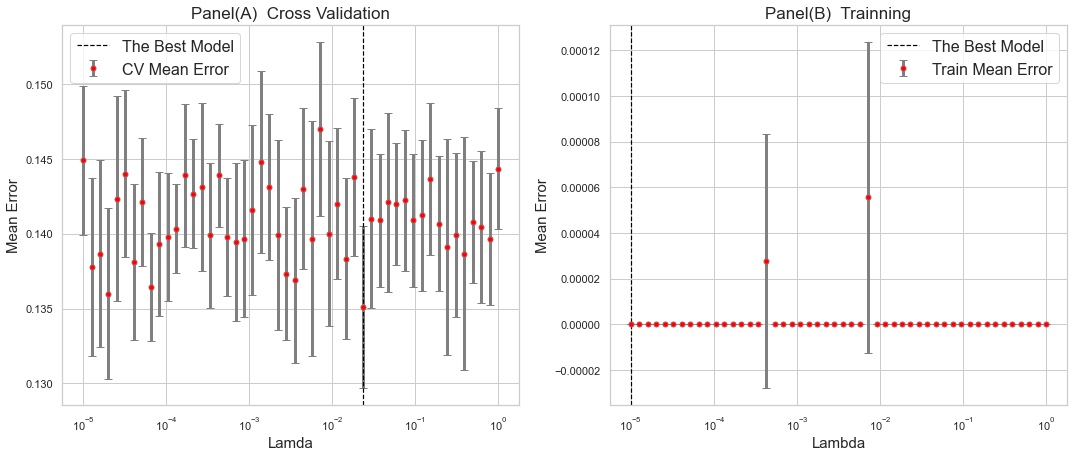

In [483]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.errorbar(lambdas, CV_mean    #x, y数据，一一对应
             , yerr=CV_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )                      #误差棒边界线厚度

plt.semilogx()
plt.axvline(lambdas[np.argmin(CV_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','CV Mean Error'], fontsize=16)
plt.xlabel('Lamda', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(A)  Cross Validation", fontsize = 17)
plt.subplot(1, 2, 2)
plt.errorbar(lambdas, error_mean    #x, y数据，一一对应
             , yerr=error_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=5                             #数据点大小
             , mfc="red"                          #数据点颜色
             , mec="r"                          #数据点边缘颜色
             , ecolor="grey"               #误差棒颜色
             , elinewidth=3                     #误差棒线宽
             , capsize=4                        #误差棒边界线长度
             , capthick=1
            )
plt.semilogx()
plt.axvline(lambdas[np.argmin(error_mean)],color = 'black',ls="--", lw=1.2)
plt.legend(['The Best Model','Train Mean Error'], fontsize=16)
plt.xlabel('Lambda', fontsize = 15)
plt.ylabel('Mean Error', fontsize = 15)
plt.title("Panel(B)  Trainning", fontsize = 17)
plt.show()

###### 得到最优模型

In [493]:
best_lambda = lambdas[np.argmin(CV_mean)]
best_lambda

0.0035564803062231283

In [563]:
param_dict = {'objective': 'multi:softmax',
              'n_estimators': 1000,
              'num_class': 10,
              'eta': best_eta, 
              'alpha': best_alpha,
              'lambda': best_lambda,
              'eval_metric': 'mlogloss'}

In [564]:
xgb_model_3 = xgb.XGBClassifier(**param_dict)
xgb_model_3.fit(train, y_train)  # 拟合

xgb_result3 = xgb_model_3.predict(test, iteration_range = (0, 1000) )
np.mean(xgb_result3 == y_test)

0.8636666666666667

In [510]:
xgb_cv = xgb.cv(param_dict, dtrain, 
            num_boost_round=1000, 
            nfold=10, stratified=True,
            early_stopping_rounds=15, metrics='merror')
result4 = np.array(xgb_cv)

[17:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used

In [511]:
result4.shape
CV_mean = result4[:, 2]
CV_std = result4[:, 3]
error_mean = result4[:, 0]
error_std = result4[:, 1]

In [512]:
htick_ls = range(1, result4.shape[0] + 1)

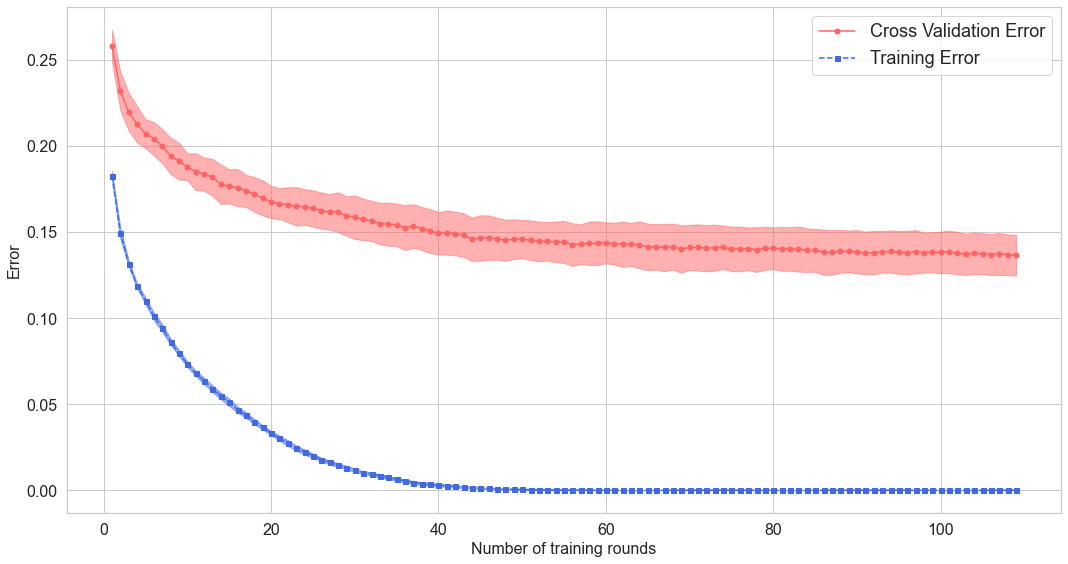

In [516]:
plt.figure(figsize=(15, 8))

plt.plot(htick_ls, CV_mean,
         color="#FF6464", marker='o',
         markersize=5, label='Cross Validation Error')
plt.fill_between(htick_ls,
                 CV_mean + CV_std,
                 CV_mean - CV_std,
                 alpha=0.5, color="#FF6464")
plt.plot(htick_ls, error_mean,
         color='royalblue', linestyle='--',
         marker='s', markersize=5,
         label='Training Error')
plt.fill_between(htick_ls,
                 error_mean + error_std,
                 error_mean - error_std,
                 alpha=0.5, color='royalblue')
#plt.grid()
#plt.semilogx()
plt.xlabel('Number of training rounds', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()
plt.show()

###### 绘制混淆矩阵

In [561]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_true = deepcopy(y_test) # 样本实际标签
y_pred = deepcopy(xgb_result3)  # 样本预测标签

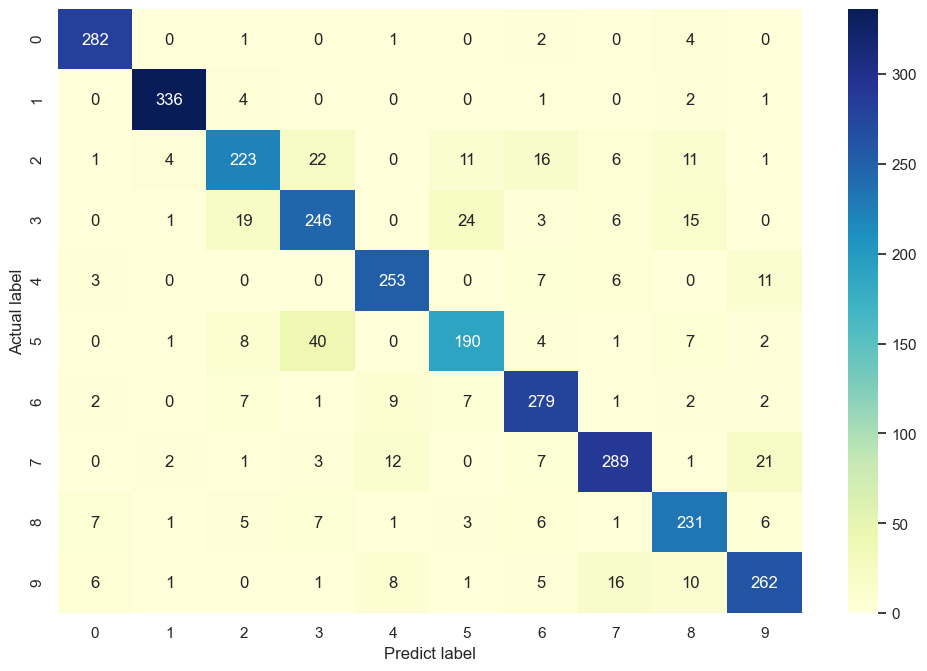

In [576]:
# 获取混淆矩阵
#plt.axis('off')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8), dpi=100)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='.20g')
plt.ylabel('Actual label')
plt.xlabel('Predict label')
plt.show()